In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -qq /content/drive/MyDrive/text_extraction_dataset.zip

In [ ]:
!pip install ultralytics

In [ ]:
import albumentations as A
from tqdm import tqdm
from ultralytics import YOLO
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import os
import cv2
import torch

In [ ]:
class TEDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):

        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_names = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        label_path = os.path.join(self.label_dir, image_name.lower().replace('.jpg', '.txt'))
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        bboxes = []
        class_ids = []
        if os.path.exists(label_path):

          with open(label_path, 'r') as f:
              lines = f.readlines()

              if not lines:
                  bboxes = []
                  class_ids = []
              else:
                  for line in lines:
                    class_id, x_center, y_center, width, height = map(float, line.strip().split())
                    if all(0 < coord <= 1 for coord in [x_center, y_center, width, height]):
                        class_ids.append(int(class_id))
                        bboxes.append([x_center, y_center, width, height])
        else:
            bboxes = []
            class_ids = []

        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes, class_ids=class_ids)
            image = transformed['image']
            bboxes = transformed['bboxes']
            class_ids = transformed['class_ids']

        #return image, torch.tensor(bboxes, dtype=torch.float32), torch.tensor(class_ids, dtype=torch.int64)
        return image, bboxes, class_ids

base_dataset = TEDataset(
    image_dir="/content/text_extraction_dataset/dataset/images",
    label_dir="/content/text_extraction_dataset/dataset/labels",
    transform=None
)

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, augmentations_count, transform1, transform2):
        self.base_dataset = base_dataset
        self.augmentations_count = augmentations_count
        self.dataset_length = len(base_dataset) * (augmentations_count + 1)

    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        base_idx = idx // (self.augmentations_count + 1)
        aug_idx = idx % (self.augmentations_count + 1)

        image, bboxes, class_ids = self.base_dataset[base_idx]

        #if aug_idx == 0:
        transformed = transform1(image=image, bboxes=bboxes, class_ids=class_ids)
        #else:
        #  transformed = transform2(image=image, bboxes=bboxes, class_ids=class_ids)

        image = transformed['image']
        bboxes = transformed['bboxes']
        class_ids = transformed['class_ids']

        return image, torch.tensor(bboxes, dtype=torch.float32), torch.tensor(class_ids, dtype=torch.int64)

In [ ]:
transform1 = A.Compose([
    A.Resize(768, 768),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']))

transform2 = A.Compose([
    A.Resize(768, 768),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, min_height=8, min_width=8, fill_value=0, p=0.5),
    A.Blur(blur_limit=3, p=0.3),
    ToTensorV2()
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']))

dataset = AugmentedDataset(base_dataset, augmentations_count=0, transform1=transform1, transform2=transform2)
print(f"Размер нового датасета: {len(dataset)}")

Размер нового датасета: 1198


In [ ]:
def visualize_image_with_bboxes(image, bboxes, class_ids, class_names=None):

    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()

    img_copy = image.copy()

    h, w, _ = img_copy.shape
    for bbox, class_id in zip(bboxes, class_ids):
        x_center, y_center, width, height = bbox
        x_min = int((x_center - width / 2) * w)
        y_min = int((y_center - height / 2) * h)
        x_max = int((x_center + width / 2) * w)
        y_max = int((y_center + height / 2) * h)

        color = (0, 255, 0)
        img_copy = cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color, 2)

        label = class_names[class_id] if class_names else str(class_id)
        img_copy = cv2.putText(img_copy, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()

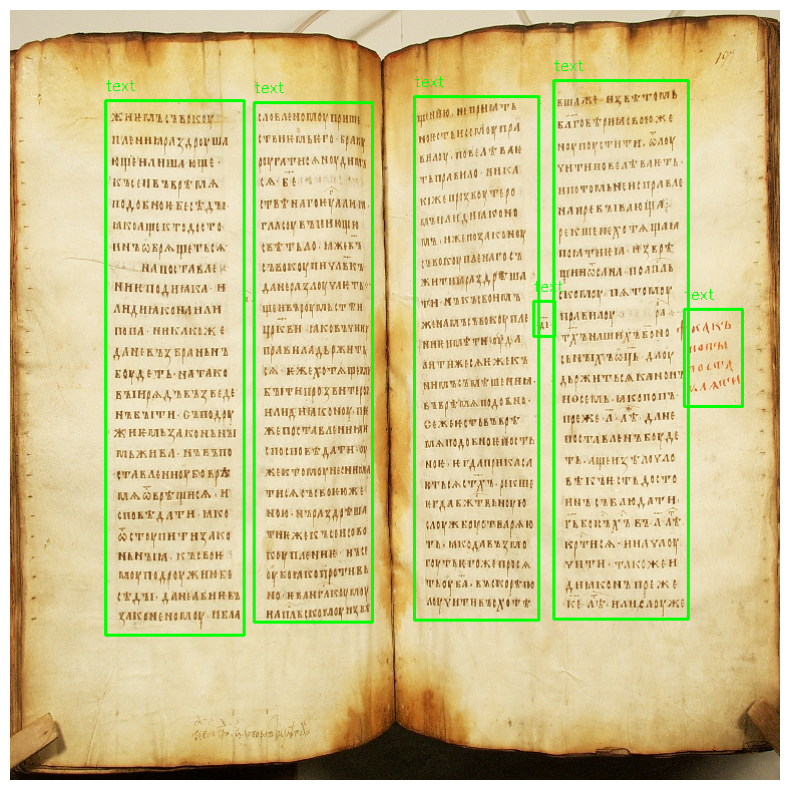

In [ ]:
image, bboxes, class_ids = dataset[234]

visualize_image_with_bboxes(
    image=image,
    bboxes=bboxes.tolist(),
    class_ids=class_ids.tolist(),
    class_names=["text"]
)

In [ ]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

print(f"Тренировочная выборка: {len(train_dataset)}")
print(f"Валидационная выборка: {len(val_dataset)}")
print(f"Тестовая выборка: {len(test_dataset)}")

Тренировочная выборка: 838
Валидационная выборка: 239
Тестовая выборка: 121


In [ ]:
output_image_dir = "/content/dataset/images/val"
output_label_dir = "/content/dataset/labels/val"
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

for idx, (image, bboxes, class_ids) in enumerate(tqdm(val_dataset)):
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_path = os.path.join(output_image_dir, f"{idx:06d}.jpg")
    cv2.imwrite(image_path, cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))

    label_path = os.path.join(output_label_dir, f"{idx:06d}.txt")
    with open(label_path, "w") as f:
        for box, class_id in zip(bboxes, class_ids):
            x_center, y_center, width, height = box.tolist()
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

100%|██████████| 239/239 [00:02<00:00, 94.04it/s] 


In [ ]:
model = YOLO('yolov8n.pt')
model.train(
    data='data.yaml',
    epochs=40,
    imgsz=768,
    batch=16,
    project='yolo_training',
    name='augmented_dataset',
    device=0
)

Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=768, save=True, save_period=-1, cache=False, device=0, workers=8, project=yolo_training, name=augmented_dataset2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

train: Scanning /content/dataset/labels/train.cache... 838 images, 692 backgrounds, 0 corrupt: 100%|██████████| 838/838 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/dataset/labels/val.cache... 239 images, 202 backgrounds, 0 corrupt: 100%|██████████| 239/239 [00:00<?, ?it/s]


Plotting labels to yolo_training/augmented_dataset2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 768 train, 768 val
Using 2 dataloader workers
Logging results to yolo_training/augmented_dataset2
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      4.32G      1.173      3.534      1.325         10        768: 100%|██████████| 53/53 [00:24<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        239        168          1      0.345      0.467      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      4.27G     0.9574      2.497      1.163          8        768: 100%|██████████| 53/53 [00:25<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

                   all        239        168      0.672      0.494      0.474       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      4.27G      1.046      2.574      1.261          7        768: 100%|██████████| 53/53 [00:23<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        239        168      0.762      0.342      0.362      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      4.32G     0.9688       1.64      1.184         15        768: 100%|██████████| 53/53 [00:24<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.21it/s]


                   all        239        168      0.596      0.494      0.522      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40       4.3G      0.924      1.391      1.144         22        768: 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]

                   all        239        168      0.973      0.476      0.634      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      4.31G     0.8972       1.26      1.126         18        768: 100%|██████████| 53/53 [00:22<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]


                   all        239        168      0.916      0.655      0.785      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      4.34G     0.8986       1.13      1.124          3        768: 100%|██████████| 53/53 [00:24<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.62it/s]

                   all        239        168      0.918      0.583      0.729      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40       4.3G     0.8263     0.9252      1.048          8        768: 100%|██████████| 53/53 [00:23<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


                   all        239        168      0.854      0.733      0.852      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40       4.3G     0.8626     0.9151      1.092          6        768: 100%|██████████| 53/53 [00:23<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]

                   all        239        168      0.762       0.61      0.756      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      4.31G      0.804      1.121      1.054          0        768: 100%|██████████| 53/53 [00:23<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]

                   all        239        168      0.864      0.762      0.874      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      4.29G      0.873     0.9754      1.089         12        768: 100%|██████████| 53/53 [00:23<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        239        168      0.789      0.738      0.804      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      4.28G     0.8322     0.8752      1.093          4        768: 100%|██████████| 53/53 [00:23<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

                   all        239        168      0.892      0.786      0.875      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      4.29G     0.7874     0.8473      1.044         18        768: 100%|██████████| 53/53 [00:23<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        239        168      0.799       0.78       0.85      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      4.32G     0.7799     0.8152       1.04         13        768: 100%|██████████| 53/53 [00:25<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]

                   all        239        168      0.921       0.69      0.813      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      4.29G      0.775     0.8289      1.058          4        768: 100%|██████████| 53/53 [00:24<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]

                   all        239        168      0.876       0.72      0.834      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      4.32G     0.7198     0.7761      1.043          6        768: 100%|██████████| 53/53 [00:22<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.66it/s]

                   all        239        168      0.886       0.74      0.873      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      4.32G      0.735     0.7015      1.021          3        768: 100%|██████████| 53/53 [00:24<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]

                   all        239        168      0.837      0.796      0.878      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      4.27G     0.6981     0.6936      1.018          8        768: 100%|██████████| 53/53 [00:22<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]

                   all        239        168       0.91      0.783      0.854      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      4.27G     0.6968     0.6887      1.034          9        768: 100%|██████████| 53/53 [00:24<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


                   all        239        168      0.843      0.827      0.906      0.707

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40       4.3G     0.6851     0.6433      1.005          9        768: 100%|██████████| 53/53 [00:23<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]

                   all        239        168      0.897      0.779      0.897      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      4.34G     0.7186     0.6764      1.027          5        768: 100%|██████████| 53/53 [00:24<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        239        168      0.923       0.78      0.901      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      4.31G     0.6653     0.6623       1.01          8        768: 100%|██████████| 53/53 [00:23<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]

                   all        239        168      0.931      0.833      0.934      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      4.27G     0.6516     0.7031     0.9747          0        768: 100%|██████████| 53/53 [00:23<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]

                   all        239        168      0.848       0.81      0.908       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40       4.3G     0.6725     0.6706     0.9878          9        768: 100%|██████████| 53/53 [00:26<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]

                   all        239        168      0.729      0.887      0.896      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      4.27G     0.6316       0.65      1.005         11        768: 100%|██████████| 53/53 [00:25<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        239        168      0.925      0.815      0.907      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      4.28G      0.652     0.6234      1.002          4        768: 100%|██████████| 53/53 [00:22<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.25it/s]

                   all        239        168      0.883      0.902       0.93      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      4.32G     0.6606     0.6538      1.006          4        768: 100%|██████████| 53/53 [00:24<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]

                   all        239        168       0.91      0.847      0.932      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      4.32G     0.6886     0.6227      1.011          5        768: 100%|██████████| 53/53 [00:23<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.47it/s]

                   all        239        168      0.868      0.875      0.926      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40       4.3G     0.6477     0.5761     0.9986         19        768: 100%|██████████| 53/53 [00:23<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.86it/s]

                   all        239        168      0.942      0.874      0.947      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      4.32G     0.6361      0.668      0.977         12        768: 100%|██████████| 53/53 [00:22<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.79it/s]

                   all        239        168      0.858      0.869      0.926      0.773


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      4.27G     0.6015     0.8163     0.9707         12        768: 100%|██████████| 53/53 [00:25<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.70it/s]

                   all        239        168      0.923      0.893      0.947       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40       4.3G     0.5935     0.8642     0.9146          8        768: 100%|██████████| 53/53 [00:21<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.35it/s]

                   all        239        168       0.91      0.815      0.931      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40       4.3G     0.6057     0.7133      0.972          5        768: 100%|██████████| 53/53 [00:21<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]

                   all        239        168      0.927      0.875      0.956      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      4.28G     0.6034     0.6059      0.982          1        768: 100%|██████████| 53/53 [00:26<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.44it/s]

                   all        239        168      0.967       0.86      0.959      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      4.29G     0.5522     0.7046     0.9399          9        768: 100%|██████████| 53/53 [00:21<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]

                   all        239        168      0.904      0.875      0.945      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      4.27G     0.5635      0.624     0.9786         23        768: 100%|██████████| 53/53 [00:23<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]

                   all        239        168       0.93      0.869      0.958      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      4.32G     0.5234     0.6481     0.9721         10        768: 100%|██████████| 53/53 [00:22<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

                   all        239        168      0.949       0.89      0.968      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      4.26G     0.5435     0.5089     0.9676          8        768: 100%|██████████| 53/53 [00:22<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.07it/s]

                   all        239        168       0.96      0.887      0.969      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      4.27G     0.5186     0.6045     0.8793         10        768: 100%|██████████| 53/53 [00:22<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.35it/s]

                   all        239        168      0.954      0.887      0.968      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40       4.3G     0.5508     0.5442     0.9608          1        768: 100%|██████████| 53/53 [00:21<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        239        168      0.948      0.899       0.97      0.835



40 epochs completed in 0.320 hours.
Optimizer stripped from yolo_training/augmented_dataset2/weights/last.pt, 6.3MB
Optimizer stripped from yolo_training/augmented_dataset2/weights/best.pt, 6.3MB

Validating yolo_training/augmented_dataset2/weights/best.pt...
Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


                   all        239        168      0.948      0.899       0.97      0.836
Speed: 0.5ms preprocess, 8.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to yolo_training/augmented_dataset2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x796b2687c650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
metrics = model.val(
    data='data.yaml',
    imgsz=768,
    batch=8,
    device=0
)

Ultralytics 8.3.65 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/dataset/labels/val.cache... 239 images, 202 backgrounds, 0 corrupt: 100%|██████████| 239/239 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 30/30 [00:05<00:00,  5.45it/s]


                   all        239        168      0.947      0.899       0.97      0.835
Speed: 1.0ms preprocess, 9.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to yolo_training/augmented_dataset22


In [ ]:
model = YOLO('best (2).pt')

image_path = '/content/5fcfc0d58dec333480f6c3ec-preview.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = model.predict(image_rgb)

for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        class_id = int(box.cls[0])
        confidence = box.conf[0]

        print(f"Class ID: {class_id}, Confidence: {confidence}, Box coordinates: {x1, y1, x2, y2}")


0: 768x608 1 text, 19.8ms
Speed: 6.8ms preprocess, 19.8ms inference, 1.9ms postprocess per image at shape (1, 3, 768, 608)
Class ID: 0, Confidence: 0.8048833608627319, Box coordinates: (tensor(415.2099, device='cuda:0'), tensor(172.6860, device='cuda:0'), tensor(1445.2509, device='cuda:0'), tensor(1638.9559, device='cuda:0'))


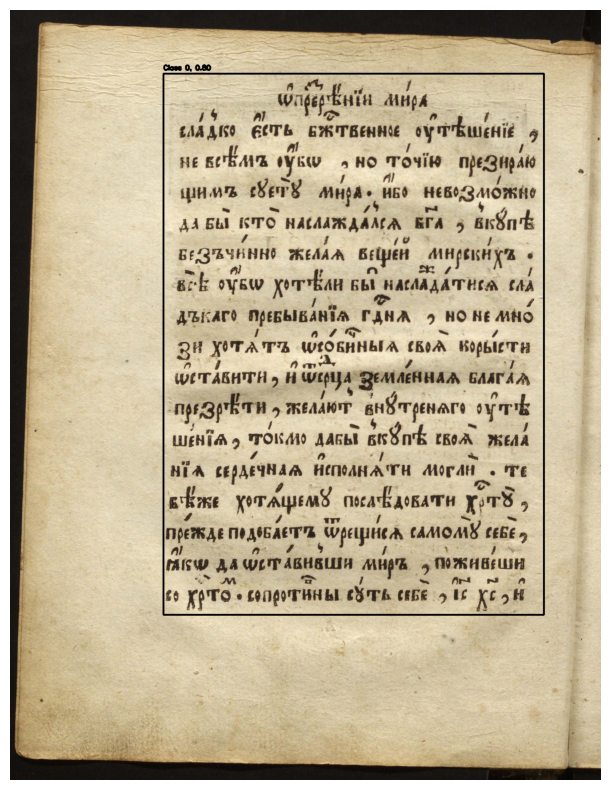

In [ ]:
for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        class_id = int(box.cls[0])
        confidence = box.conf[0]

        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 0), 3)

        label = f"Class {class_id}, {confidence:.2f}"
        cv2.putText(image, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 3)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()